In [1]:
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import display, FileLink
import numpy as np
from multiprocessing.pool import Pool

%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 18,
        "font.size": 18,
        "legend.fontsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
})

In [2]:
def gridreduce_sim (d, M, N=None, T=None, W=None, p=0.01, seed=1337):
    """
    :param d: dimension of grid
    :param M: side of the grid
    :param N: number of alive clients, will be full if None
    :param T: number of iterations
    :param W: weights, 1d array with length N
    :param p: probability for being unavailable
    :param seed: seed for random weights
    :return: list of variances on each iteration
    """
    res = []
    true_shape = [M for i in range(d)]
    if N == None:
        N = M**d
    if T == None:
        T = 3*d//2
    if W is None:
        W = np.random.normal(0, 1, N).astype(np.float32)
    alive_indices = np.random.choice(M ** d, size=N, replace=False)
    mask = np.bincount(alive_indices, minlength=M**d)
    mask = np.zeros(M ** d, dtype=np.float32)
    mask[alive_indices] = 1
    mask = mask.reshape(true_shape)

    current_weights = np.zeros(M ** d, dtype=np.float32)
    current_weights[alive_indices] = W
    current_weights = current_weights.reshape(true_shape)
    
    #calculate variance
    res.append(current_weights.flatten()[alive_indices].var())
    
    for t in range(T):
        #generate new mask
        alive_mask = np.zeros(M ** d, dtype=np.float32)+1
        alive_mask[alive_indices] = np.random.choice(2, size=N, p=(p, 1-p))
        alive_mask = alive_mask.reshape(true_shape)
        alive_mask = alive_mask.all(axis=t%d, keepdims=True)
        alive_mask = np.repeat(alive_mask, M, axis=t%d)
        current_mask = alive_mask*mask

        #update weights
        sums = (current_weights*current_mask).sum(axis=t%d, keepdims=True)
        count = np.maximum(1, current_mask.sum(axis=t%d, keepdims=True))
        new_weights = np.repeat(sums/count, true_shape[t%d], axis=t%d)*current_mask
        current_weights = new_weights + current_weights*(1-current_mask)

        #calculate variance
        res.append(current_weights.flatten()[alive_indices].var())
    return res

def run_job(args):
    d, M, N, T, prob, job_seed = args
    return gridreduce_sim(d, M, N, T, None, prob, job_seed)

def experiment(prob, T=15, d=3, M=100, N=None, num_iters=20, n_jobs=8, seed=1337):
    """
    :param prob: probability for being unavailable
    :param T: number of iterations
    :param d: dimension of grid
    :param M: side of the grid
    :param N: number of alive clients, will be full if None
    :param num_iters: number of restarts for averaging measurements
    :param n_jobs: number of parallel processes
    :param seed: seed for random weights
    :return: list of variances on each iteration
    """
    res = np.zeros((T+1,))
    for j in range(0, num_iters, n_jobs):
        with Pool(n_jobs) as pool:
            results = pool.map(run_job,
                               [(d, M, N, T, prob, seed + i) for i in range(min(n_jobs, num_iters-j))])
        for i in range(min(n_jobs, num_iters-j)):
            res += results[i]
    return res/num_iters

In [3]:
eps = np.finfo(np.float64).eps
cube32_d2_p0_N1000    = experiment(prob=0,     d=2, M=32, T=20, N=900, num_iters=40) + eps
cube32_d2_p0001_N1000 = experiment(prob=0.001, d=2, M=32, T=20, N=900, num_iters=40) + eps
cube32_d2_p0002_N1000 = experiment(prob=0.002, d=2, M=32, T=20, N=900, num_iters=40) + eps
cube32_d2_p0004_N1000 = experiment(prob=0.004, d=2, M=32, T=20, N=900, num_iters=40) + eps

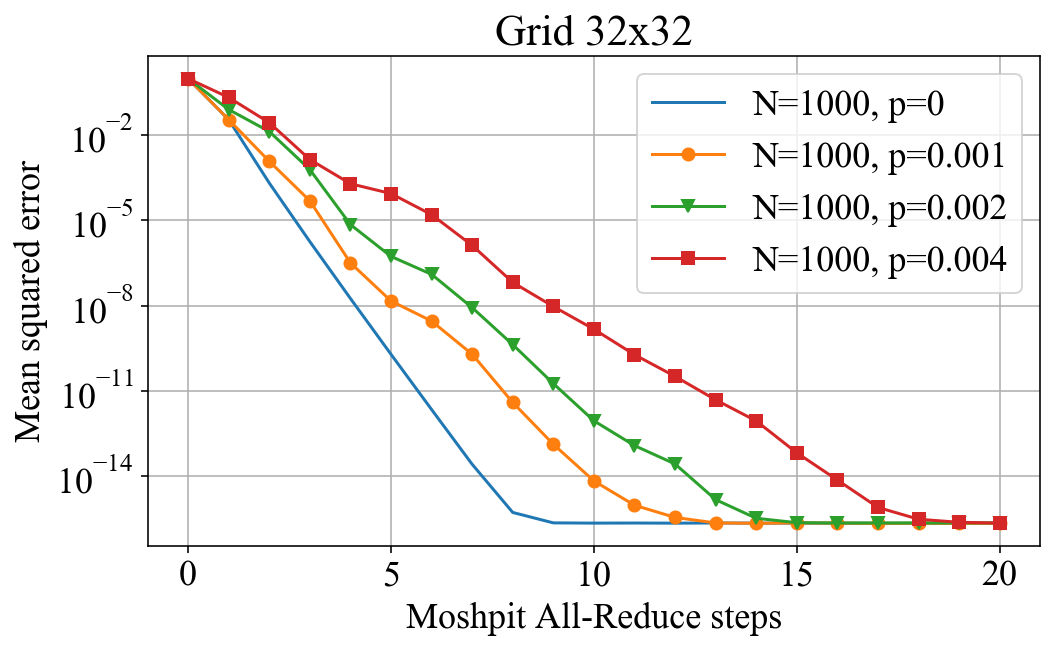

In [4]:
plt.figure(figsize=[8, 4.5])
plt.plot(cube32_d2_p0_N1000, label="N=1000, p=0")
plt.plot(cube32_d2_p0001_N1000, label="N=1000, p=0.001", marker='o')
plt.plot(cube32_d2_p0002_N1000, label="N=1000, p=0.002", marker='v')
plt.plot(cube32_d2_p0004_N1000, label="N=1000, p=0.004", marker='s')

plt.title("Grid 32x32")
plt.xlabel("Moshpit All-Reduce steps")
plt.ylabel("Mean squared error")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()